In [1]:
from sympy import symbols,solve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import HTML
import urllib.request

In [2]:
HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
#HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer

# Symbolic Math with Python
v1.311, 26 February 2018, by Brian Fiedler
$\newcommand{\V}[1]{\vec{\boldsymbol{#1}}}$
$\newcommand{\I}[1]{\widehat{\boldsymbol{\mathrm{#1}}}}$
$\newcommand{\pd}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\pdt}[1]{\frac{\partial#1}{\partial t}}$
$\newcommand{\ddt}[1]{\frac{\D#1}{\D t}}$
$\newcommand{\D}{\mathrm{d}}$
$\newcommand{\Ii}{\I{\imath}}$
$\newcommand{\Ij}{\I{\jmath}}$
$\newcommand{\Ik}{\I{k}}$
$\newcommand{\del}{\boldsymbol{\nabla}}$
$\newcommand{\dt}{\cdot}$
$\newcommand{\x}{\times}$
$\newcommand{\dv}{\del\cdot}$
$\newcommand{\curl}{\del\times}$
$\newcommand{\lapl}{\nabla^2}$

Demonstrates using `sympy` to solve for the mysterious coefficients we see in the Adams-Bashforth schemes and the advection schemes.

## Simple examples of solving linear equations

`symbols`: The names on the left will be the Python names of a variable, the symbols on the right will be what is printed. It is a good idea to keep them the same...

In [3]:
z = 7 # traditional python variable assignment
p = symbols('q') # a bad idea to label the symbol object other than 'p'

print("any suprises here?")
print(type(z),z)
print(type(p),p)

any suprises here?
<class 'int'> 7
<class 'sympy.core.symbol.Symbol'> q


In [4]:
# The "= 0" is assumed in the equation that we solve:
solve(p/2 -1)

[2]

In [5]:
# There was only one variable, so we didn't see the name. Show name of what we solved for:
solve(p/2 -1, dict=True)

[{q: 2}]

### Two independent equations, two unknowns

In [6]:
# Normally, you should make the python variable name the same as the printed name.
x,y = symbols('x,y')

Let's solve these for $x$ and $y$:
$$x-y+1=0$$
$$x+4y-5=0$$
In `solve`, the equations that we are solving don't need the "= 0".  That is assumed.
Because we are solving for two unknowns, we get the answer as a python dictionary. `dict=True` is the default.

In [7]:
solve( [ x-y+1, x+4*y-5] , [x,y] )

{y: 6/5, x: 1/5}

### Three dependent equations

A system of linear equations may have an infinite number of solutions if the equations are not independent.

In [8]:
x,y,z = symbols('x,y,z')

In [9]:
solve( [ x + 2*y + 3*z - 4, 5*x + 6*y +7*z -8 , 9*x + 10*y + 11*z - 12 ], [x,y,z] )

{y: -2*z + 3, x: z - 2}

### Inconsistent equations

A system of linear equations may have no solution. For example, equations for two lines that do not intersect.

In [10]:
x,y = symbols('x,y')

In [11]:
solve( [ x-y+1, x-y+2] , [x,y] )

[]

##  Deriving third-order upwind advection

In `AdvectionPDE1d.ipynb`,  we found that the derivative $\pd{f}{x}$ used in an equation like:
$$
\pdt{f} = -u\pd{f}{x}
$$
could be estimated in a variety of ways.  Those we mentioned were "second-order centered", "first-order upwind" and
"third-order upwind". 

Here we will derive the "third-order upwind" scheme for $\pd{f}{x}$. As for the claim of being "third-order"  we will note that the derivative is estimated from a third-order polynomial, fit to 4 discrete points of $f$. It is "upwind" because two points upwind of $\pd{f}{x}$ are used, and one point downwind.

We attempt to fit:
$$ f(x) = f(0) + a \frac{x}{\delta} +b \frac{x^2}{\delta^2} 
+c \frac{x^3}{\delta^3} $$

If we can find $a$, $b$ and $c$ that fit the three neighboring points, then
$f'(0) = a/\delta$ may be suitable for the derivative we need in an advection scheme. 

$$f(\delta) = f(0) +a +b + c $$

$$f(-\delta) = f(0) - a + b - c $$

$$f(-2\delta) = f(0) - 2a + 4b - 8c $$

In [12]:
f0,fp1,fm1,fm2,a,b,c = symbols('f0,fp1,fm1,fm2,a,b,c')
# fm1 is "f at minus 1 delta", fp1 is "f at plus 1 delta", and so on

In [13]:
# the variable names np1, nm1, nm2 are the names of "expression objects":
np1 = f0 + a + b + c - fp1 
nm1 = f0 -a + b - c - fm1
nm2 = f0 -2*a + 4*b - 8*c -fm2
soln = solve([np1,nm1,nm2],[a,b,c]) # "expression objects" are set equal to zero to be "equations"
soln

{b: -f0 + fm1/2 + fp1/2,
 c: -f0/2 + fm1/2 - fm2/6 + fp1/6,
 a: f0/2 - fm1 + fm2/6 + fp1/3}

So seeing the solution for $a$ above:
$$ f'(0) = \frac{a}{\delta} = \frac{1}{6\delta} \left[ f(-2\delta) -6f(-\delta) + 3 f(0) + 2 f(\delta) \right] $$

You should now be able to see where this python code for third-order upwind advection comes from:

`dbdx[2:-2] = (b[:-4]  - 6*b[1:-3] + 3*b[2:-2] + 2*b[3:-1])/(6*dx)`


#### Example of the "fit" provided by the polynomial

What is the fitted polynomial doing for us? Let's do an example with specific values of $f$ at the four points: an upside-down V or "spike". 

In [14]:
from collections import OrderedDict # if you want OrderedDict instead of dict

In [15]:
fs = [fm2, fm1, f0, fp1] # list of our symbols
vals = [0,1,2,1] # the values of f showing the spike
spike = OrderedDict(zip(fs,vals))# associate symbols with specific values
#spike= dict(zip(fs,vals)) # this works too
print(spike)

OrderedDict([(fm2, 0), (fm1, 1), (f0, 2), (fp1, 1)])


In [16]:
# Now substitute in those specific values of fm2,fm1,f0,fp1 to
# get numbers for a,b,c
coefs={} # initialize empty dict
for key in soln:
    coefs[key] = soln[key].subs(spike) # subs means subsitute
print(coefs)

{b: -1, c: -1/3, a: 1/3}


In this example $\delta=1$. For the spike, we find $a=\frac{1}{3}$.  So "third-order upwind" estimate is $f'(0)=\frac{1}{3}$ 

Let's use those coefficients, specific to this "spike" example, to plot the fitted function, and maybe see where this estimate comes from.

In [17]:
xa = np.linspace(-2,1,31) # this is the range of x/delta for the plot
xa

array([-2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. ,
       -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,
        0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [18]:
# this is the fitted f(x)
f = spike[f0] + coefs[a]*xa + coefs[b]*xa**2 + coefs[c]*xa**3 
f

array([0, 0.0429999999999997, 0.104000000000000, 0.181000000000000,
       0.272000000000000, 0.375000000000000, 0.488000000000000,
       0.609000000000000, 0.736000000000000, 0.867000000000000,
       1.00000000000000, 1.13300000000000, 1.26400000000000,
       1.39100000000000, 1.51200000000000, 1.62500000000000,
       1.72800000000000, 1.81900000000000, 1.89600000000000,
       1.95700000000000, 2, 2.02300000000000, 2.02400000000000,
       2.00100000000000, 1.95200000000000, 1.87500000000000,
       1.76800000000000, 1.62900000000000, 1.45600000000000,
       1.24700000000000, 1.00000000000000], dtype=object)

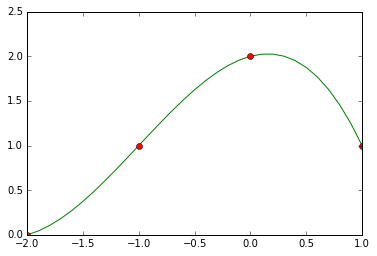

In [19]:
plt.plot(xa,f,'g-')
plt.plot([-2,-1,0,1],vals,'ro');

Well, so what?  
You should be able to see by inspection of the above spike that a "second-order centered" scheme would produce $f'(0)=0$,
and the "first-order upwind" scheme produces $f'(0)=1$.  We haven't shown that the above third-order "fit" of $f'(0)=\frac{1}{3}$ is necesarily "better" than other alternatives when used in an advection scheme. In METR 4323, the proof about being "better" is shown by experiments.


<hr/>
## Adams-Bashforth time step

The universal forecast scheme is (trivially):
$$f(t+\delta) = f(t) + \int_t^{t+\delta} f'(s) ds = f(t) + \delta \frac{1}{\delta}\int_t^{t+\delta} f'(s) ds $$
On this side of the pond, the $s$ is called a *dummy variable* for $t$.
Needless to say, knowing $f'(t)$ in the future is problematic, because we don't know the
future.  The simplest scheme is to assume $f'(s)$ will be $f'(t)$. That is the Euler scheme.

It may be helpful to denote the average value of $f'(t)$ over the next time step as:
$$ \overline{f'(t)} = \frac{1}{\delta}\int_t^{t+\delta} f'(s) ds $$

So our universal forecast scheme is also denoted:

$$f(t+\delta) = f(t) + \delta \overline{f'(t)} $$


Let's make a better estimate of $f'(t)$ in the near future. Let's call the current time $t=0$.
We seek $a$ and $b$ in
$$ f'(t)=f'(0)+a\frac{t}{\delta}+ b\frac{t^2}{\delta^2}$$
where $a$ and $b$ are determined by the requirement for $f'(t)$ to also fit the
values of $f'(t)$ in the previous time steps:
$$ f'(-\delta) = f'(0) - a + b$$
$$ f'(-2\delta) = f'(0) - 2a + 4b$$

The average value of $f'(t)$ between $t=0$ and $t=\delta$ is thus anticpated to be:
$$\overline{f'(t)} =
\frac{1}{\delta}\int_0^\delta 
\left( f'(0)+ a\frac{s}{\delta}+ b \frac{s^2}{\delta^2} \right)ds
 =\frac{1}{\delta} 
 \left[ f'(0)s +
 \frac{1}{2} a\frac{s^2}{\delta} 
 + \frac{1}{3} b \frac{s^3}{\delta^2}\right]_0^\delta
 =f'(0)+ \frac{1}{2} a + \frac{1}{3} b$$

We next use `sympy` to find $a$ and $b$ in terms of $f'(0)$,  $f'(-\delta)$ and  $f'(-2\delta)$.

In [20]:
fp0,fpm1,fpm2,a,b = symbols('fp0,fpm1,fpm2,a,b')

In [21]:
nm1 = fp0 -a + b - fpm1
nm2 = fp0 -2*a + 4*b - fpm2
ab =solve([nm1,nm2],(a,b))  # the solution
ab

{b: fp0/2 - fpm1 + fpm2/2, a: 3*fp0/2 - 2*fpm1 + fpm2/2}

So here is $\overline{f'(t)}$ in terms of $f'(0)$, $f'(-\delta)$ and $f'(-2\delta)$:

In [22]:
fp0+ab[a]/2+ab[b]/3

23*fp0/12 - 4*fpm1/3 + 5*fpm2/12

You should see the similarity with our Python code for 3rd-order Adams-Bashforth:

`(23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.`

<hr>
# Fifth-order upwind advection

$$ f(x) = f(0) + a X + b X^2 + c X^3 + d X^4 + e X^5 $$
where $X \equiv x/\delta$. 

We have values $f(-3\delta)$, $f(-2\delta)$, $f(-\delta)$,
$f(\delta)$ and $f(2\delta)$ to fit by finding the appropriate values for $a$, $b$, $c$, $d$ and $e$.

| $\LaTeX\qquad$ |`python` |
| --- | --- |
| $f(-3\delta)$ | f0 |
| $f(-2\delta)$ | f1 |
| $f(-1\delta)$ | f2 |
| $f(0)$ | f3 |
| $f(\delta)$ | f4 |
| $f(2\delta)$ | f5 |

In [23]:
f0,f1,f2,f3,f4,f5,a,b,c,d,e = symbols('f0,f1,f2,f3,f4,f5,a,b,c,d,e')

In [24]:
np2 = f3 + 2*a + 4*b + 8*c + 16*d + 32*e -f5
np1 = f3 + a + b + c + d + e - f4
nm1 = f3 -a + b - c + d - e - f2
nm2 = f3 -2*a + 4*b - 8*c + 16*d - 32*e - f1
nm3 = f3 -3*a + 9*b - 27*c + 81*d - 243*e - f0
solve([np2,np1,nm1,nm2,nm3],(a,b,c,d,e))

{e: -f0/120 + f1/24 - f2/12 + f3/12 - f4/24 + f5/120,
 b: -f1/24 + 2*f2/3 - 5*f3/4 + 2*f4/3 - f5/24,
 c: f0/24 - 7*f1/24 + 7*f2/12 - 5*f3/12 + f4/24 + f5/24,
 a: -f0/30 + f1/4 - f2 + f3/3 + f4/2 - f5/20,
 d: f1/24 - f2/6 + f3/4 - f4/6 + f5/24}

$\frac{\partial b}{\partial x} = \frac{a}{\delta}$ can be used in an advection scheme. This is what python code might look like for $\frac{\partial b}{\partial x}$ in the 5th order upwind scheme:


`dbdx[3:-2] = (-2*b[:-5]  + 15*b[1:-4] - 60*b[2:-3] + 20*b[3:-2] + 30*b[4:-1] -3*b[5:0])/(60*dx)`

Note there are 3 points to the left, and 2 points to the right, of the point where we want the derivative to apply. This should be appropriate for flow from the left.

<hr/>
## Student Task 1: Fourth-order centered advection

This should be easy.  Let's just truncate the above 5th order analysis to 4th order.

$$ f(x) = f(0) + a X + b X^2 + c X^3 + d X^4 $$
where $X \equiv x/\delta$. 

We have values $f(-2\delta)$, $f(-\delta)$,
$f(\delta)$ and $f(2\delta)$ to fit by finding the appropriate values for $a$, $b$, $c$ and $d$.

| $\LaTeX\qquad$|`python` |
| --- | --- |
| $f(-2\delta)$ | f1 |
| $f(-1\delta)$ | f2 |
| $f(0)$ | f3 |
| $f(\delta)$ | f4 |
| $f(2\delta)$ | f5 |

**STUDENTS:** finish the sympy stuff for the 4th order scheme:

<hr/>
# Student Task 2: Implement the 4th and 5th order advection schemes

Make a copy of your `AdvectionPDE1d.ipynb` into something like `MoreAdvection.ipynb`. Modify the new notebook to include options for `advord=4` and `advord=5`.  Do some experiments to make pretty plots comparing the 1 thru 5 schemes.  I suggest you use N=101 points. 